## Training a Random Forests Model

In [15]:
import os

from qsprpred.models import SklearnModel
from qsprpred.data import QSPRDataset
from qsprpred.models import OptunaOptimization
from qsprpred.models import CrossValAssessor
from sklearn.ensemble import RandomForestClassifier
from qsprpred.data import RandomSplit, BootstrapSplit
from qsprpred.data.descriptors.fingerprints import MorganFP


os.makedirs("../output/models", exist_ok=True)

# Read receptor name from the text file
#with open("../output/data/receptor.txt", "r") as file:
 #   receptor = file.read().strip() #this is temporarily commented out to focus on new filtered hERG dataset compared to orginal

dataset = QSPRDataset.fromTableFile(
    filename=f"../output/data/hERG_Dataset_filtered.tsv",
    store_dir="../output/data",
    name=f"SplittinghERG_F_Dataset",
    target_props=[{"name": "pchembl_value_Mean", "task": "SINGLECLASS", "th": [6.5]}],
    random_state=42
)


In [36]:
less /home/s2787504/QSPRpred/qsprpred/data/descriptors/fingerprints.py


"""Fingerprint classes."""
from abc import ABC
from typing import Any

import numpy as np
import pandas as pd
from rdkit import DataStructs, Chem
from rdkit.Avalon import pyAvalonTools
from rdkit.Chem import AllChem, MACCSkeys, rdMolDescriptors, rdmolops, Mol

from qsprpred.data.descriptors.sets import DescriptorSet


class Fingerprint(DescriptorSet, ABC):
    """Base class for calculation of binary fingerprints.

    Attributes:
        usedBits (list): list of bits of the fingerprint currently being used
    """

    def __init__(self, used_bits: list[int] | None = None):
        super().__init__()
        self.usedBits = used_bits or list(range(len(self)))

    @property
    def usedBits(self) -> list[int] | None:
        return self._usedBits

    @usedBits.setter
    def usedBits(self, value: list[int]):
        self._usedBits = sorted(value)

    @property
    def descriptors(self) -> list[str]:
        return [f"{self}_{i}" for i in self.usedBits]

    @descriptors.setter
    de

In [ ]:
from qsprpred.data.chem.clustering import ScaffoldClusters
from qsprpred.data.chem.scaffolds import BemisMurckoRDKit
from qsprpred.data import ClusterSplit

#Create the ScaffoldClusters object (this defines the clustering strategy)
molecule_clusters = ScaffoldClusters(
    scaffold=BemisMurckoRDKit()  # Use the default scaffold generator
)


# Morgan Fingerprints
dataset.addDescriptors([MorganFP(radius=3, nBits=2048)])




#Create the ClusterSplit object, passing the molecule_clusters strategy
cluster_split = ClusterSplit(
    dataset=dataset,        # Your QSPRDataset
    test_fraction=0.2,      # 20% test split
    clustering=molecule_clusters,
    seed=42
)

#Run the split. This will trigger clustering internally.
dataset.split(cluster_split)

#Confirm split success
def print_split(ds):
    train, test = ds.getFeatures()
    print(train.shape)
    print(test.shape)


print_split(dataset)


qsprpred - WARNING - Molecular descriptors already exist in SplittinghERG_F_Dataset. Calculation will be skipped. Use `recalculate=True` to overwrite them.


(7624, 2048)
(4085, 2048)


In [59]:
from rdkit import Chem
from rdkit.Chem import Descriptors, MACCSkeys
import numpy as np
import pandas as pd
from qsprpred.data.descriptors.fingerprints import MorganFP
from qsprpred.models import SklearnModel, OptunaOptimization, CrossValAssessor
from qsprpred.data import ClusterSplit
from qsprpred.data.chem.clustering import ScaffoldClusters
from qsprpred.data.chem.scaffolds import BemisMurckoRDKit
from qsprpred.data import BootstrapSplit, RandomSplit
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split



molecule_clusters = ScaffoldClusters(scaffold=BemisMurckoRDKit())

cluster_split = ClusterSplit(
    dataset=dataset,
    test_fraction=0.2,
    clustering=molecule_clusters,
    seed=42
)

#dataset.split(cluster_split)



#XGBoost Model with Optuna
model = SklearnModel(
    base_dir="../output/models/",
    alg=XGBClassifier,
    name=f"Splitting_hERG_F_XGBModel",
    random_state=dataset.randomState
)

search_space_bs = {
    "n_estimators": ["int", 10, 1000],
    "max_depth": ["int", 3, 25],
    "learning_rate": ["float", 0.01, 0.3],
    "subsample": ["float", 0.5, 1.0],
    "colsample_bytree": ["float", 0.5, 1.0]
}


# Use the custom split in BootstrapSplit
optimizer = OptunaOptimization(
    param_grid=search_space_bs,
    n_trials=100,
    model_assessor=CrossValAssessor(
        scoring="roc_auc",
        split=BootstrapSplit(split=RandomSplit(0.2), n_bootstraps=5)
    )
)

optimizer.optimize(model, dataset)


qsprpred - WARNING - Explicitly specified random state (42)will override model settings read from file: 42.
[I 2025-03-19 16:49:57,552] A new study created in memory with name: no-name-840647c6-4a0a-4b5c-820e-cefae7f7913f
[W 2025-03-19 17:03:37,244] Trial 0 failed with parameters: {'n_estimators': 381, 'max_depth': 24, 'learning_rate': 0.22227824312530747, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/s2787504/.conda/envs/qsprpred/lib/python3.13/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "/home/s2787504/QSPRpred/qsprpred/models/hyperparam_optimization.py", line 247, in <lambda>
    lambda t: self.objective(t, model, ds), self.nTrials, n_jobs=self.nJobs
              ~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/home/s2787504/QSPRpred/qsprpred/models/hyperparam_optimization.py", line 301, in objective
   

KeyboardInterrupt: 

In [29]:

properties = dataset.getProperties()
print(properties)

# Get data from your QSPR dataset (assuming it's a pandas DataFrame)
# Extract features (all columns except the target)
X = dataset.drop(columns=['Activity_class', 'pchembl_value', 'pchembl_value_Mean'])  # Drop target and pchembl_value columns
y = dataset['Activity_class']  # Target variable

# Check class balance
print("Class balance in Activity_class:")
print(y.value_counts(normalize=True))


train_y, test_y = dataset.getProperties()

print("Train class balance:")
print(train_y.value_counts(normalize=True))
print("Test class balance:")
print(test_y.value_counts(normalize=True))


['Activity_ID', 'Quality', 'source', 'CID', 'SMILES', 'connectivity', 'InChIKey', 'InChI', 'InChI_AuxInfo', 'target_id', 'TID', 'accession', 'Protein_Type', 'AID', 'doc_id', 'Year', 'all_doc_ids', 'all_years', 'type_IC50', 'type_EC50', 'type_KD', 'type_Ki', 'type_other', 'Activity_class', 'relation', 'pchembl_value', 'pchembl_value_Mean', 'pchembl_value_StdDev', 'pchembl_value_SEM', 'pchembl_value_N', 'pchembl_value_Median', 'pchembl_value_MAD', 'first_AID', 'chembl_id', 'assay_type', 'QSPRID', 'pchembl_value_Mean_original']


AttributeError: 'QSPRDataset' object has no attribute 'drop'

In [ ]:


# Create the splitter
split = RandomSplit(test_fraction=0.2)

# Split the dataset
dataset.split(split)

# Check split sizes
print_split(dataset)

model = SklearnModel( #test with new model types
    base_dir="../output/models/",
    alg=RandomForestClassifier,
    name="SplittinghERG_F_Model",
    random_state=dataset.randomState
)
search_space_bs = {"n_estimators": ["int", 10, 100, 250]}
optimizer = OptunaOptimization(
    param_grid=search_space_bs,
    n_trials=6,  
    model_assessor=CrossValAssessor(
        scoring="roc_auc",
        split=BootstrapSplit(split=RandomSplit(0.2), n_bootstraps=5)
    )
)
optimizer.optimize(model, dataset)

qsprpred - WARNING - Explicitly specified random state (42)will override model settings read from file: 42.
[I 2025-03-18 11:45:19,551] A new study created in memory with name: no-name-dc067a9c-4773-4221-9b1e-dccdf91c5a73


(9367, 2048)
(2342, 2048)
Index(['SplittinghERG_F_Dataset_09894', 'SplittinghERG_F_Dataset_04880',
       'SplittinghERG_F_Dataset_06521', 'SplittinghERG_F_Dataset_07013',
       'SplittinghERG_F_Dataset_04092', 'SplittinghERG_F_Dataset_01383',
       'SplittinghERG_F_Dataset_09677', 'SplittinghERG_F_Dataset_06889',
       'SplittinghERG_F_Dataset_08844', 'SplittinghERG_F_Dataset_04043',
       ...
       'SplittinghERG_F_Dataset_08956', 'SplittinghERG_F_Dataset_03000',
       'SplittinghERG_F_Dataset_03265', 'SplittinghERG_F_Dataset_05882',
       'SplittinghERG_F_Dataset_11359', 'SplittinghERG_F_Dataset_11348',
       'SplittinghERG_F_Dataset_01746', 'SplittinghERG_F_Dataset_04819',
       'SplittinghERG_F_Dataset_08167', 'SplittinghERG_F_Dataset_10490'],
      dtype='object', name='QSPRID', length=2342)


[I 2025-03-18 11:46:06,511] Trial 0 finished with value: 0.6800141925850258 and parameters: {'n_estimators': 44}. Best is trial 0 with value: 0.6800141925850258.
[I 2025-03-18 11:47:47,085] Trial 1 finished with value: 0.6818608158108035 and parameters: {'n_estimators': 96}. Best is trial 1 with value: 0.6818608158108035.
[I 2025-03-18 11:49:09,123] Trial 2 finished with value: 0.6814536630987152 and parameters: {'n_estimators': 76}. Best is trial 1 with value: 0.6818608158108035.
[I 2025-03-18 11:50:15,412] Trial 3 finished with value: 0.6812726843393605 and parameters: {'n_estimators': 64}. Best is trial 1 with value: 0.6818608158108035.
[I 2025-03-18 11:50:40,514] Trial 4 finished with value: 0.6763280140651349 and parameters: {'n_estimators': 24}. Best is trial 1 with value: 0.6818608158108035.
[I 2025-03-18 11:51:05,567] Trial 5 finished with value: 0.6763280140651349 and parameters: {'n_estimators': 24}. Best is trial 1 with value: 0.6818608158108035.


{'n_estimators': 96}

### Bootstrapping with optimized model

In [ ]:
# run bootstrapping ten times with the optimized model
CrossValAssessor(
    scoring="roc_auc",
    split=BootstrapSplit(split=RandomSplit(0.2), n_bootstraps=10)
)(model, dataset)

array([0.73852521, 0.74505441, 0.74296544, 0.74758646, 0.73638993,
       0.72316902, 0.73777976, 0.7162591 , 0.71652274, 0.71919969])

In [ ]:
# evaluate on the test set as well
from qsprpred.models import TestSetAssessor

TestSetAssessor(scoring="roc_auc")(model, dataset)

array([0.64595063])

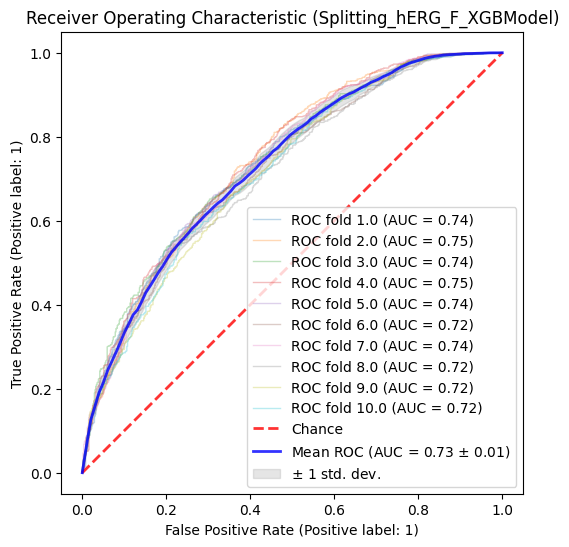

[<Figure size 600x600 with 1 Axes>]

<Figure size 640x480 with 0 Axes>

In [ ]:
# plot the results for bootstrapping
from qsprpred.plotting.classification import ROCPlot

plot = ROCPlot([model])
plot.make(save=True, show=True, property_name=model.targetProperties[0].name,
          validation="cv")

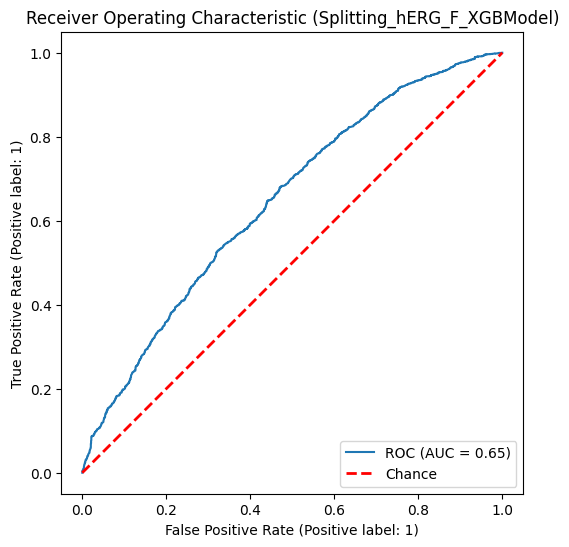

[<Figure size 600x600 with 1 Axes>]

<Figure size 640x480 with 0 Axes>

In [ ]:
# plot test set results
plot.make(save=True, show=True, property_name=model.targetProperties[0].name,
          validation="ind")

## Cross validation using ScaffoldSplit

In [ ]:
from qsprpred.data import ScaffoldSplit
from qsprpred.models import SklearnModel
from qsprpred.models import CrossValAssessor

CrossValAssessor(
    scoring="roc_auc",
    split=ScaffoldSplit(n_folds=10, scaffold=BemisMurckoRDKit())
)(model, dataset)

array([0.77500893, 0.63965636, 0.64471678, 0.60997014, 0.64409815,
       0.647455  , 0.66858348, 0.69339378, 0.72669677, 0.72876755])

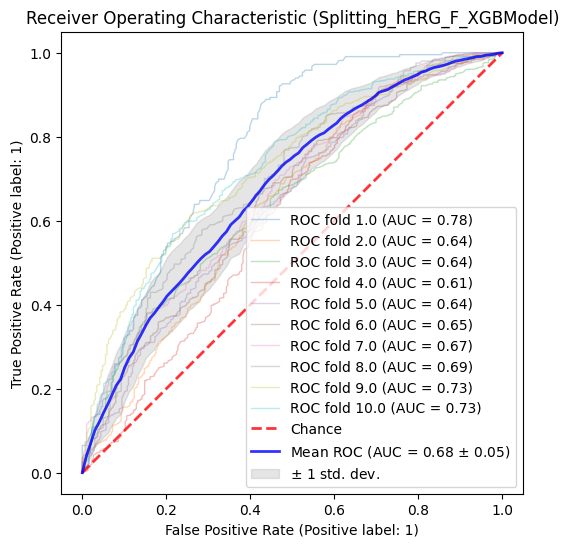

[<Figure size 600x600 with 1 Axes>]

<Figure size 640x480 with 0 Axes>

In [ ]:
plot.make(save=True, show=True, property_name=model.targetProperties[0].name,
          validation="cv")

## Cross validation using Temporal split

<Axes: >

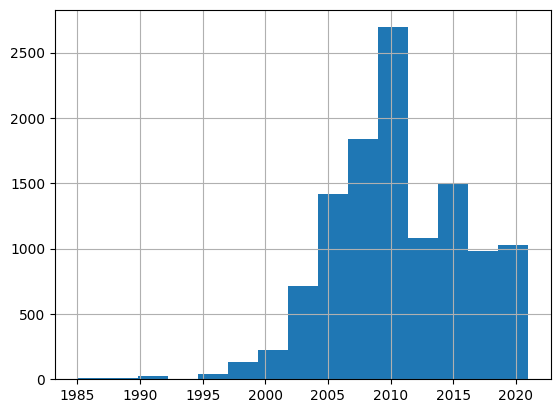

In [ ]:
dataset.getProperty("Year").hist(bins=15)

In [ ]:
from qsprpred.data import TemporalSplit

CrossValAssessor(
    scoring="roc_auc",
    split=TemporalSplit(timesplit=[2000, 2010, 2020], timeprop="Year")
)(model, dataset)

array([0.52729757, 0.60080936, 0.46003899])

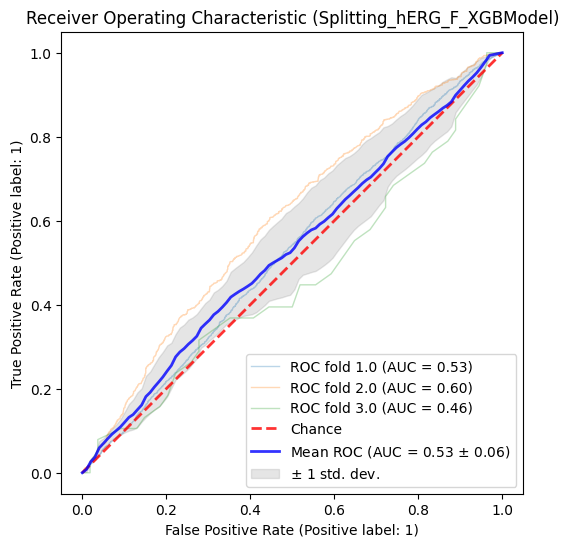

[<Figure size 600x600 with 1 Axes>]

<Figure size 640x480 with 0 Axes>

In [ ]:
plot.make(save=True, show=True, property_name=model.targetProperties[0].name,
          validation="cv")

These splits are not saved to the dataset, but the assessments and optimizations can be reproduced by setting the random state to the same value. You can also explicitly save the splits to by adding a monitor to the `ModelAssessor` or `HyperparameterOptimizer`, see the [monitoring tutorial](../../advanced/modelling/monitoring.ipynb) for more information.

### Making predictions

In [ ]:
smiles_list = ["c1(cc(c(O)cc1)O)CCN", "CC(=O)OC1=CC=CC=C1C(=O)O",
               "CC(C)CC1=CC=C(C=C1)C(C)C(=O)O"]

model.predictMols(smiles_list)

NotFittedError: need to call fit or load_model beforehand

### Reloading

In [ ]:
dataset = QSPRDataset.fromFile(
    "./output/data/{receptor}_Dataset/{receptor}Dataset_meta.json")
model = SklearnModel.fromFile(
    "./output/models/{receptor}_Model/QuickStartModel_meta.json")
# or
dataset = QSPRDataset(
    name="{receptor}_Dataset",
    store_dir="./data/",
)
model = SklearnModel(
    name="{receptor}Model",
    base_dir="./output/models/"
)